In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


# Download historical data for a stock symbol
symbol = '^NSEI'
df = yf.download(symbol, start="2010-01-01", end="2020-01-01")

[*********************100%%**********************]  1 of 1 completed


In [17]:
stock_list = ['IGL',
'JBMA',
'MPHASIS',
'SYNGENE',
'BIOCON',
'INDIAMART',
'ADANIGREEN',
'LTTS',
'WIPRO',
'DABUR',
'NSLNISP',
'ADANIENSO',
'ZYDUSLIFE',
'SONACOMS',
'RELIANCE',
'CLEAN',
'REDINGTON',
'GUJGASLTD',
'KAJARIACER',
'ALKYLAMINE',
'PIDILITIND',
'PAGEIND',
'BANDHANBNK',
'DIVISLAB',
'AKZOINDIA',
'ATUL',
'GRINFRA',
'RAJESHEXPO',
'NAVINFLUOR',
'ATGL',
'POLICYBZR',
'AEGISCHEM',
'TRITURBINE',
'TATACOMM',
'FINEORG',
'AETHER',
'LAURUSLABS',
'INFY',
'FINCABLES',
'CGPOWER',
'FINPIPE',
'BDL']


In [18]:
# Calculate the 14 day RSI
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (delta.where(delta < 0, 0).abs()).rolling(window=14).mean()
RS = gain / loss
df['RSI'] = 100 - (100 / (1 + RS))

# Calculate the MACD
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
macd = exp1-exp2
signal = macd.ewm(span=9, adjust=False).mean()
df['MACD'] = macd - signal

# Calculate EMA (let's use a 9-day EMA)
df['EMA'] = df['Close'].ewm(span=9, adjust=False).mean()


In [19]:
# Calculate the slope of the RSI
rsi = df['RSI'].values
x = np.arange(len(rsi))
slope = np.polyfit(x, rsi, 1)[0]  # we take [0] because polyfit returns slope and intercept

df['RSI_Slope'] = np.gradient(df['RSI'])  # this calculates the slope over the axis of points, effectively giving the change of RSI


In [20]:
buy_signals = [np.nan]
sell_signals = [np.nan]

for i in range(1, len(df)):
    # For this example, let's say we buy if RSI is below 30 (oversold) and the RSI slope is positive (indicating a reversal).
    if df['RSI'][i] < 30 and df['RSI_Slope'][i] > 0:
        buy_signals.append(df['Close'][i])
        sell_signals.append(np.nan)
    # Sell if RSI is above 70 (overbought) and the RSI slope is negative.
    elif df['RSI'][i] > 70 and df['RSI_Slope'][i] < 0:
        buy_signals.append(np.nan)
        sell_signals.append(df['Close'][i])
    else:
        buy_signals.append(np.nan)
        sell_signals.append(np.nan)

# Add signals to dataframe
df['Buy_Signals'] = buy_signals
df['Sell_Signals'] = sell_signals


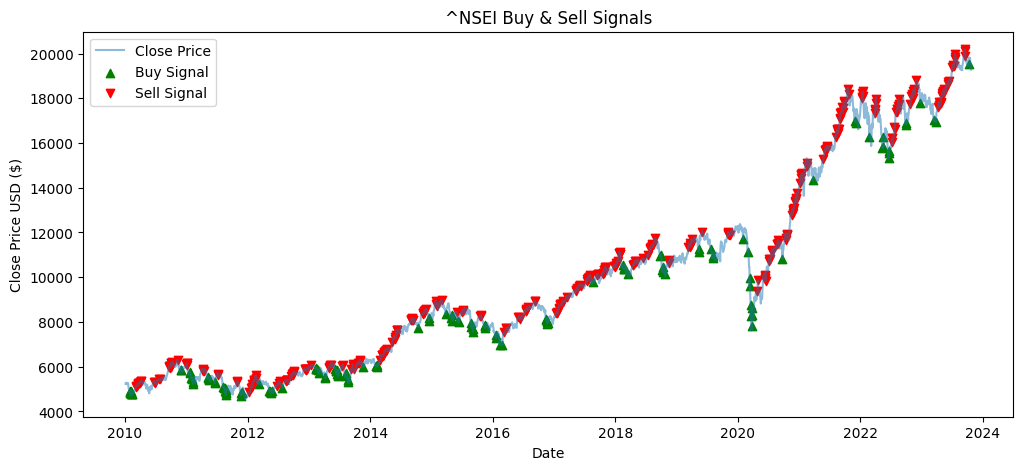

In [21]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.scatter(df.index, df['Buy_Signals'], label='Buy Signal', marker='^', color='green')
plt.scatter(df.index, df['Sell_Signals'], label='Sell Signal', marker='v', color='red')
plt.title(f'{symbol} Buy & Sell Signals')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()


Strategy return: 159.16%
Buy and hold return: 268.52%


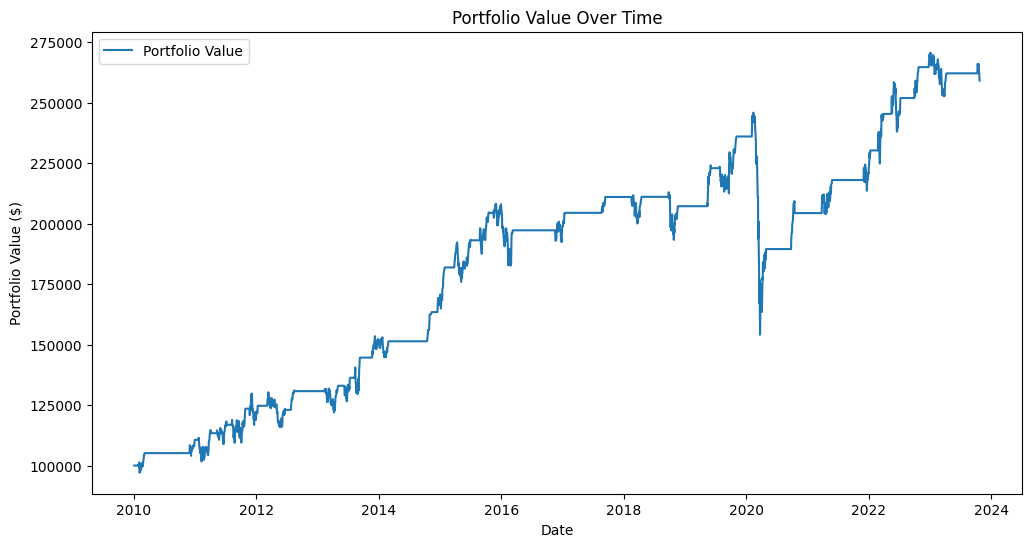

In [22]:
# Simulate portfolio starting with a certain cash amount and no stocks.
initial_cash = 100000
cash = initial_cash
current_stocks = 0
portfolio = []

# We'll iterate over the DataFrame rows.
for i in range(len(df)):
    price = df['Close'][i]

    # Check if we have a buy signal and enough cash to buy at least one stock.
    if not np.isnan(df['Buy_Signals'][i]) and cash >= price:
        stocks_to_buy = cash // price  # This will floor the division to get whole stocks
        current_stocks += stocks_to_buy
        cash -= stocks_to_buy * price  # Reducing cash by the cost of stocks bought

    # Check if we have a sell signal and stocks to sell.
    elif not np.isnan(df['Sell_Signals'][i]) and current_stocks > 0:
        cash += current_stocks * price  # Increasing cash by the price of stocks sold
        current_stocks = 0  # Selling all stocks

    # Calculate portfolio value and append to list.
    portfolio_value = cash + current_stocks * price
    portfolio.append(portfolio_value)

# Add portfolio value to the dataframe.
df['Portfolio_Value'] = portfolio

# Calculate the strategy's final returns compared to buy-and-hold strategy.
strategy_return = (df['Portfolio_Value'].iloc[-1] - initial_cash) / initial_cash
buy_and_hold_return = (df['Close'].iloc[-1] - df['Close'].iloc[0]) / df['Close'].iloc[0]

print(f"Strategy return: {strategy_return * 100:.2f}%")
print(f"Buy and hold return: {buy_and_hold_return * 100:.2f}%")

# Plot the portfolio value over time.
plt.figure(figsize=(12,6))
plt.plot(df['Portfolio_Value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()
